<a href="https://colab.research.google.com/github/vir-dom/Artificial_Incoherence/blob/main/deeplearning_artificial_incoherence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello! This is the project of the team called Artificial Incoherence, for our Deep Learning class. Our names are (with neptun codes): Dominika Virsinger (RSABSD), Csaba Medgyes (RF8I8P) and Bálint Gergő (O78UXU). For later Python updates here we should collect all the necessary packages and functions.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import savetxt
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import pickle

#This allows us to connect Drive with Colab. A pop-up will ask you for signing in and authorizing it.
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#open in Colab

### Data collecting

Now we want to import out dataset from Kaggle. It contains about 20000 labeled images of faces, considering ethnicity, age, gender. It has certain encoding in its filename, so we should import their names also. If you want to get more information from the dataset see: https://susanqq.github.io/UTKFace/ and https://www.kaggle.com/datasets/jangedoo/utkface-new?fbclid=IwAR0X1gR-ad1WuZH2QymWFyu_6ZIPmyj4m-9Y8H-5gn4f4kDD5BE8dm2xPJQ, now we only mention the necessary part for the code.

The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

- [age] is an integer from $0$ to $116$, indicating the age
- [gender] is either $0$ (male) or $1$ (female)
- [race] is an integer from $0$ to $4$, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

We have many options. We suggested that for all target variable (age, gender, race) we use a seperate model, but we are not sure yet. We will clarify this later before the modelling part. Since our dataset is publicly available we should import it from Kaggle.

### Data processing



First we create a dataframe, where the key values are going to be the image names, and next to those will appear the age, gender and race attributes. This dataframe will be used to make an exploratory data analysis, and to split the images into train and test sets. After that, we are going to use the RGB values of the pixels as attributes.

We downloaded the UTKFace dataset from kaggle, and then we uploaded the images to Google Drive to share those with each other. We also loaded the images into colab from Drive, this can be seen below.

In [ ]:
path_current = '/content/drive/MyDrive/archive/UTKFace'

os.chdir(path_current)

image_names = os.listdir(path_current)

In [ ]:
print(len(image_names))
print(image_names[:3])

23720
['82_0_1_20170111210240036.jpg.chip.jpg', '7_0_0_20170110225021990.jpg.chip.jpg', '90_0_0_20170117174931541.jpg.chip.jpg']


We need to exclude the 3 cases when the race is not included (temp(2) does not exist in this case.)

In [ ]:
np.random.seed(23)
np.random.shuffle(image_names)

age_labels, gender_labels, race_labels, image_path = [], [], [], []

for image_name in image_names:
    image_path.append(image_name)
    temp = image_name.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    if len(image_name) < 36:        #the name of the picture should be at least 36 characters, if none of the labels are missing
      race_labels.append("somethingiswrong")
    else:
      race_labels.append(temp[2])

In [ ]:
image_path[0:5]

['49_0_0_20170104184239893.jpg.chip.jpg',
 '65_0_3_20170117191735066.jpg.chip.jpg',
 '26_0_1_20170117195724773.jpg.chip.jpg',
 '2_1_0_20170109192428145.jpg.chip.jpg',
 '24_0_3_20170104214346781.jpg.chip.jpg']

Let's turn the unstructured data into a structured dataframe:

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['race'] = image_path, age_labels, gender_labels, race_labels

In [ ]:
df.head()

,image,age,gender,race
0,49_0_0_20170104184239893.jpg.chip.jpg,49,0,0
1,65_0_3_20170117191735066.jpg.chip.jpg,65,0,3
2,26_0_1_20170117195724773.jpg.chip.jpg,26,0,1
3,2_1_0_20170109192428145.jpg.chip.jpg,2,1,0
4,24_0_3_20170104214346781.jpg.chip.jpg,24,0,3


In [ ]:
gender_dict = {0:"Male",1:"Female"}
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Other"}

Before we can set the types of the columns, we need to check whether there are any mistakes in the data (missing values or mistakes for example):

In [ ]:
df.describe()

,image,age,gender,race
count,23720,23720,23720,23720
unique,23720,106,3,6
top,49_0_0_20170104184239893.jpg.chip.jpg,26,0,0
freq,1,2197,12401,10088


Age has 106 unique values. This could be right according to the description of the data. Gender has 3 unique values, so it cannot be good. Race has 6 unique values, since we have 0,1,2,3,4 and 'somethingiswrong'.

In [ ]:
elements = []

for i in df['race']:
  if i not in elements:
    elements.append(i)
    
print(elements)

['0', '3', '1', '2', '4', 'somethingiswrong']


As we can see, there are three pictures where the race was not given in the image name. Regarding that we have 20k+ images, we can easily drop these three, so the missing values won't cause any problem.

In [ ]:
elements[5]

'somethingiswrong'

In [ ]:
df.drop(df[df['race'] == elements[5]].index, inplace=True)

In [ ]:
len(df)

23715

Let's check the data again:

In [ ]:
df.describe()

,image,age,gender,race
count,23715,23715,23715,23715
unique,23715,104,2,5
top,49_0_0_20170104184239893.jpg.chip.jpg,26,0,0
freq,1,2197,12401,10088


<p>As we can see, we corrected the mistakes.</p>
<p>Now we can set the type of the columns.</p>

In [ ]:
df = df.astype({'age':'int32', 'gender': 'int32', 'race': 'int32'})

Let's see how we can open an image:

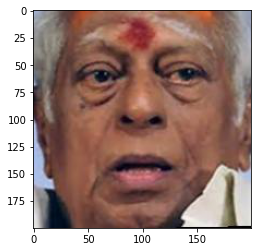

In [ ]:
img = Image.open(path_current+'/'+df.image[1])
plt.imshow(img)

Now let's see some images with the labels written above them:

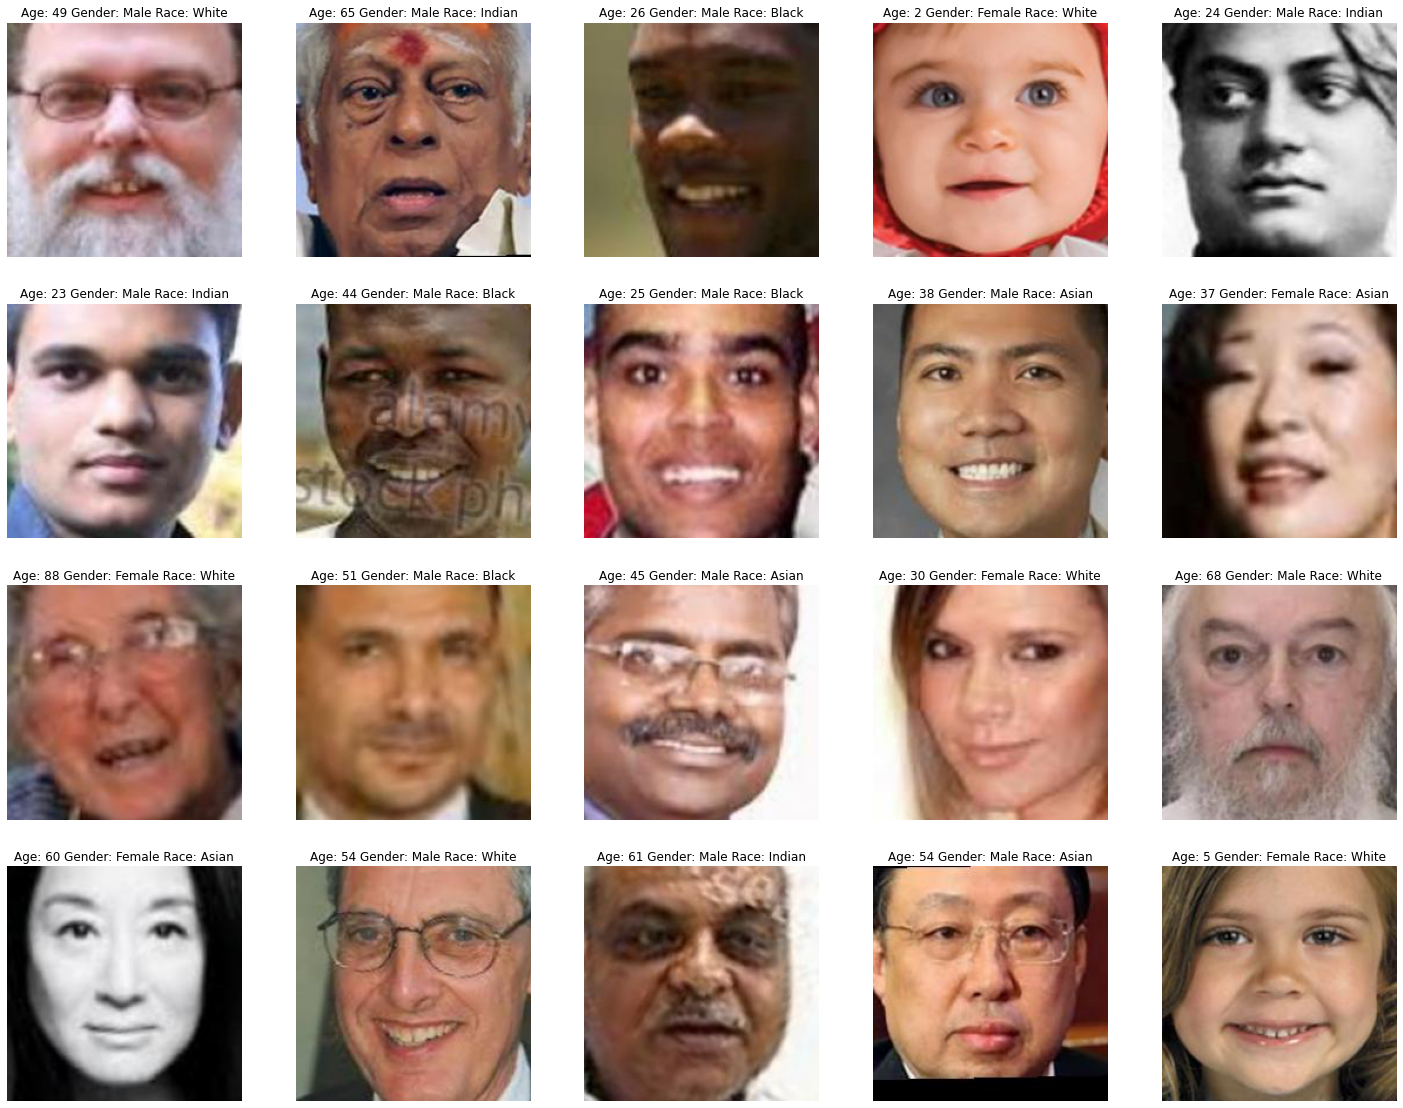

In [ ]:
files = df.iloc[0:20]
plt.figure(figsize=(25,25))
for index, file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(path_current+'/'+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]} Race: {race_dict[race]}")
    plt.axis('off')

### Exploratory data analysis

To understand better the given data, it is very common to make some plots regarding the target variables (labels).

In [ ]:
print("Statistics of age attribute:")
print(df.age.describe())

Statistics of age attribute:
count    23715.000000
mean        33.298672
std         19.881813
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64


In [ ]:
#making a dict where we count the occurences of the ages

age_count = dict()
for i in df['age']:
  age_count[i] = age_count.get(i, 0) + 1

In [ ]:
#making it sorted for plotting

age_count_sorted = dict(sorted(age_count.items()))

<BarContainer object of 104 artists>

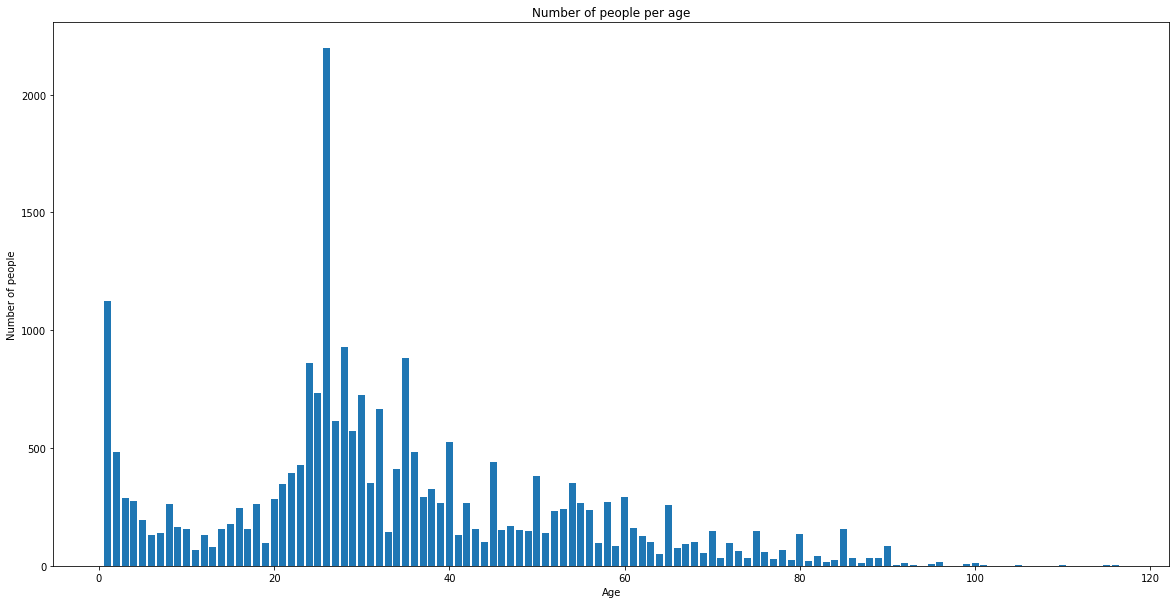

In [ ]:
#plotting the histogram

plt.figure(figsize=(20,10))
plt.title("Number of people per age")
plt.xlabel("Age")
plt.ylabel("Number of people")
plt.bar(age_count_sorted.keys(), age_count_sorted.values())

In [ ]:
#making a dict where we count the occurences of the races

race_count = dict()
for i in df['race']:
  race_count[i] = race_count.get(i, 0) + 1

In [ ]:
#making it sorted for plotting

race_count_sorted = dict(sorted(race_count.items()))

In [ ]:
race_count_sorted

{0: 10088, 1: 4526, 2: 3434, 3: 3975, 4: 1692}

In [ ]:
#changing the key values to the name of the races

v1 = race_count_sorted[0]
del race_count_sorted[0]
race_count_sorted['White'] = v1

v2 = race_count_sorted[1]
del race_count_sorted[1]
race_count_sorted['Black'] = v2

v3 = race_count_sorted[2]
del race_count_sorted[2]
race_count_sorted['Asian'] = v3

v4 = race_count_sorted[3]
del race_count_sorted[3]
race_count_sorted['Indian'] = v4

v5 = race_count_sorted[4]
del race_count_sorted[4]
race_count_sorted['Other'] = v5

In [ ]:
race_count_sorted

{'White': 10088, 'Black': 4526, 'Asian': 3434, 'Indian': 3975, 'Other': 1692}

<BarContainer object of 5 artists>

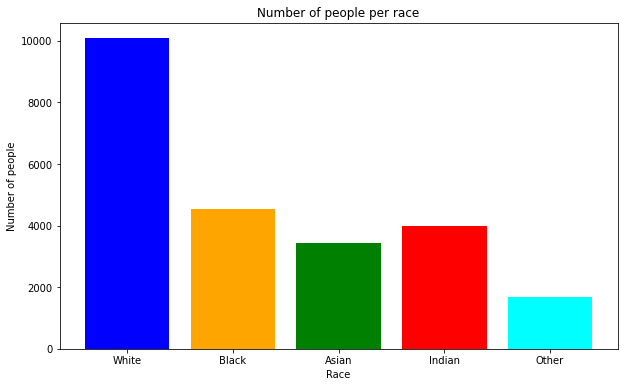

In [ ]:
#plotting the histogram

plt.figure(figsize=(10,6))
plt.title("Number of people per race")
plt.xlabel("Race")
plt.ylabel("Number of people")
plt.bar(race_count_sorted.keys(), race_count_sorted.values(), color=['blue','orange','green','red','cyan'])

In [ ]:
#making a dict where we count the occurences of the genders

gender_count = dict()
for i in df['gender']:
  gender_count[i] = gender_count.get(i, 0) + 1

In [ ]:
gender_count

{0: 12401, 1: 11314}

In [ ]:
#changing the key values to the name of the genders

v6 = gender_count[0]
del gender_count[0]
gender_count['Male'] = v6

v7 = gender_count[1]
del gender_count[1]
gender_count['Female'] = v7

<BarContainer object of 2 artists>

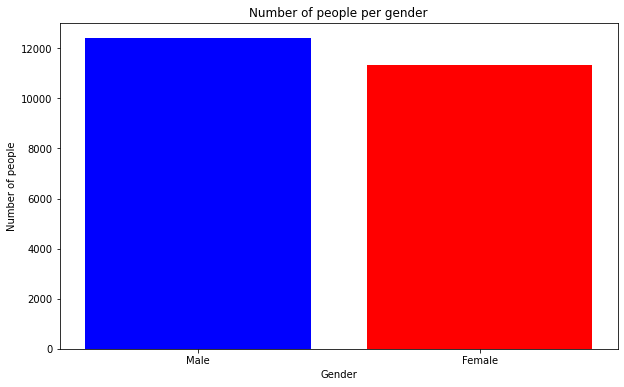

In [ ]:
#plotting the histogram

plt.figure(figsize=(10,6))
plt.title("Number of people per gender")
plt.xlabel("Gender")
plt.ylabel("Number of people")
plt.bar(gender_count.keys(), gender_count.values(),color=['blue', 'red'])

### Splitting data into train and test sets

We decided to split the data into train and test sets, and we do not make a validation set right now. It is because at modelling we will be able to easily give a percentage, what part of the training data to use as a validation set.

In [ ]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [ ]:
print(len(train))
print(len(test))

18972
4743


Now we do not need just the name of the images but also the RGB values from the pixels, so let's import that data as well.

In [ ]:
train.image[0]

'2_0_1_20170110213724790.jpg.chip.jpg'

In [ ]:
X_list = [np.asarray(plt.imread(name)) for name in train.image]

X_train = np.array(X_list)

"\nfor file in train.image:\n    img = load_img(path_current+'/'+file)\n    img = np.array(img)\n    X_train.append(img)\n\nX_train = np.array(X_train)"

In [ ]:
X_train.shape

(18972, 200, 200, 3)

In [ ]:
# saving X_train as pickle file
fp = "./X_train.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_train,f)

In [ ]:
X_list2 = [np.asarray(plt.imread(name)) for name in test.image]

X_test = np.array(X_list2)

In [ ]:
X_test.shape

(4743, 200, 200, 3)

In [ ]:
# saving X_test as pickle file
fp = "./X_test.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_test,f)

Saving y_train from train dataframe

In [ ]:
train.head()

,image,age,gender,race
18617,42_1_1_20170113001802155.jpg.chip.jpg,42,1,1
22153,42_1_1_20170112231620452.jpg.chip.jpg,42,1,1
5099,92_1_0_20170110183357210.jpg.chip.jpg,92,1,0
19590,32_1_3_20170104235736013.jpg.chip.jpg,32,1,3
16015,28_0_1_20170117165836339.jpg.chip.jpg,28,0,1
...,...,...,...,...
21578,34_0_3_20170119200717205.jpg.chip.jpg,34,0,3
5390,26_1_3_20170119193146682.jpg.chip.jpg,26,1,3
860,11_1_4_20170109201611941.jpg.chip.jpg,11,1,4
15795,25_1_0_20170117190527852.jpg.chip.jpg,25,1,0


In [ ]:
y_train = train[['age','gender','race']]

In [ ]:
y_train.head()

,age,gender,race
18617,42,1,1
22153,42,1,1
5099,92,1,0
19590,32,1,3
16015,28,0,1


In [ ]:
type(y_train)

pandas.core.frame.DataFrame

In [ ]:
# saving y_train as pickle file
fp = "./y_train.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(y_train,f)

Saving y_test from test dataframe

In [ ]:
test

,image,age,gender,race
4275,33_1_4_20170117174234414.jpg.chip.jpg,33,1,4
1147,1_0_2_20161219204836612.jpg.chip.jpg,1,0,2
1190,4_1_0_20170116200920314.jpg.chip.jpg,4,1,0
9733,15_0_0_20170104012102240.jpg.chip.jpg,15,0,0
7752,26_1_2_20170116180523022.jpg.chip.jpg,26,1,2
...,...,...,...,...
14238,23_1_3_20170104222224327.jpg.chip.jpg,23,1,3
20724,1_0_2_20161219200503284.jpg.chip.jpg,1,0,2
19032,47_1_0_20170117160407279.jpg.chip.jpg,47,1,0
4153,24_1_0_20170117150538420.jpg.chip.jpg,24,1,0


In [ ]:
y_test= test[['age','gender','race']]

In [ ]:
y_test.head()

,age,gender,race
4275,33,1,4
1147,1,0,2
1190,4,1,0
9733,15,0,0
7752,26,1,2


In [ ]:
# saving y_test as pickle file
fp = "./y_test.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(y_test,f)

### Normalizing X_train and X_test data



We need our data converted into float 32 in our drive so later we only need to load this part and we can leave the previous parts alone.

Here we can reload the train and test data from the saved files, so we do not have to run all the codes from the beginning.

In [ ]:
#changing directory to MyDrive, where the files are
# loading X_train data 

#medcsab_path = '/content/drive/MyDrive/Deep_Files'
virdom_path = '/content/drive/MyDrive'

#os.chdir(medcsab_path)
os.chdir(virdom_path)

In [ ]:
# loading y_train data 
with open("./y_train.pkl","rb") as f:
    y_train = pickle.load(file=f)

In [ ]:
# loading y_test data 
with open("./y_test.pkl","rb") as f:
    y_test = pickle.load(file=f)

Let's take the y_train and y_test with all the 3 target variables apart, so that we have each target variable separated.

In [ ]:
y_train_age = y_train.age
y_train_gender = y_train.gender
y_train_race = y_train.race

y_test_age = y_test.age
y_test_gender = y_test.gender
y_test_race = y_test.race

In [ ]:
#y_train age stays as it is, but if we decide that it should not be a regression then
#we will have to convert the ages into categories (like 0-10, 10-20 and so on)
y_train_gender = to_categorical(y_train_gender,2)
y_train_race = to_categorical(y_train_gender,5)

y_test_gender = to_categorical(y_test_gender,2)
y_test_race = to_categorical(y_test_gender,5)

The next important step is to normalize the data. Due to the limited RAM we need to do this part in a particular order. First we just focus on the X_test, then save it to a file. Then we need to delete the variable from the memory to deal with X_train.

In [ ]:
# loading X_test data 
with open("./X_test.pkl","rb") as f:
    X_test = pickle.load(file=f)

In [ ]:
X_train[1]

array([ 23,  18,  24, ..., 181, 124,  95], dtype=uint8)

In [ ]:
X_test = X_test.reshape(-1,200*200*3)

In [ ]:
X_test.shape

(4743, 120000)

In [ ]:
X_test = X_test/255

In [ ]:
X_test = X_test.astype("float32")

In [ ]:
X_test[4]

array([0.30588236, 0.29803923, 0.30980393, ..., 0.1764706 , 0.12156863,
       0.10980392], dtype=float32)

In [ ]:
# saving X_test as pickle file
fp = "./X_test2.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_test,f)

In [ ]:
#deleting the X_test variable from memory (it is already saved into file)
del X_test

<p>Now let's deal with X_train. It is too big to change the type at once, so we need to separate it into smaller pieces, convert those, and then concatenate the parts if needed.</p>
<p>
I am going to cut X_train into 4 parts, and do the normalization and change to float32 on each part separately. To deal with RAM, I need to delete variables to run the computations and after a part is done, I will save it to a file, so that I can delete the variable and have enough RAM for the next part.
</p>


Part1

In [ ]:
# loading X_train data
with open("./X_train.pkl","rb") as f:
    X_train = pickle.load(file=f)

In [ ]:
X_train_part1 = X_train[0:5000]

In [ ]:
del X_train

In [ ]:
X_train_part1.shape

(5000, 200, 200, 3)

In [ ]:
X_train_part1 = X_train_part1.reshape(-1,200*200*3)

In [ ]:
X_train_part1.shape

(5000, 120000)

In [ ]:
X_train_part1 = X_train_part1/255

In [ ]:
X_train_part1 = X_train_part1.astype("float32")

In [ ]:
X_train_part1[3]

array([0.42745098, 0.4       , 0.2901961 , ..., 0.30980393, 0.12941177,
       0.03529412], dtype=float32)

In [ ]:
# saving X_train_part1 as pickle file
fp = "./X_train_part1.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_train_part1,f)

In [ ]:
del X_train_part1

Part2

In [ ]:
# loading X_train data
with open("./X_train.pkl","rb") as f:
    X_train = pickle.load(file=f)

In [ ]:
X_train_part2 = X_train[5000:10000]

In [ ]:
del X_train

In [ ]:
X_train_part2.shape

(5000, 200, 200, 3)

In [ ]:
X_train_part2 = X_train_part2.reshape(-1,200*200*3)

In [ ]:
X_train_part2.shape

(5000, 120000)

In [ ]:
X_train_part2 = X_train_part2/255

In [ ]:
X_train_part2 = X_train_part2.astype("float32")

In [ ]:
X_train_part2[3]

array([0.34901962, 0.1764706 , 0.16470589, ..., 0.9882353 , 0.90588236,
       0.8       ], dtype=float32)

In [ ]:
# saving X_train_part2 as pickle file
fp = "./X_train_part2.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_train_part2,f)

In [ ]:
del X_train_part2

Part3

In [ ]:
# loading X_train data
with open("./X_train.pkl","rb") as f:
    X_train = pickle.load(file=f)

In [ ]:
X_train_part3 = X_train[10000:15000]

In [ ]:
del X_train

In [ ]:
X_train_part3.shape

(5000, 200, 200, 3)

In [ ]:
X_train_part3 = X_train_part3.reshape(-1,200*200*3)

In [ ]:
X_train_part3.shape

(5000, 120000)

In [ ]:
X_train_part3 = X_train_part3/255

In [ ]:
X_train_part3 = X_train_part3.astype("float32")

In [ ]:
X_train_part3[3]

array([0.7176471 , 0.73333335, 0.74509805, ..., 0.6039216 , 0.44313726,
       0.35686275], dtype=float32)

In [ ]:
# saving X_train_part3 as pickle file
fp = "./X_train_part3.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_train_part3,f)

In [ ]:
del X_train_part3

Part4

In [ ]:
# loading X_train data
with open("./X_train.pkl","rb") as f:
    X_train = pickle.load(file=f)

In [ ]:
X_train_part4 = X_train[15000:]

In [ ]:
del X_train

In [ ]:
X_train_part4.shape

(3972, 200, 200, 3)

In [ ]:
X_train_part4 = X_train_part4.reshape(-1,200*200*3)

In [ ]:
X_train_part4.shape

(3972, 120000)

In [ ]:
X_train_part4 = X_train_part4/255

In [ ]:
X_train_part4 = X_train_part4.astype("float32")

In [ ]:
X_train_part4[3]

array([0.02745098, 0.06666667, 0.17254902, ..., 0.03137255, 0.03529412,
       0.04313726], dtype=float32)

In [ ]:
# saving X_train_part4 as pickle file
fp = "./X_train_part4.pkl"
with open(fp,mode="wb") as f:
    pickle.dump(X_train_part4,f)

In [ ]:
del X_train_part4

In [ ]:
# how to save once it is done
# saving y_test as pickle file
#fp = "./y_test.pkl"
#with open(fp,mode="wb") as f:
#    pickle.dump(y_test,f)

Now we have the train data: X_train_part1, X_train_part2, X_train_part3, X_train_part4, y_train_age, y_train_gender, y_train_race.
We also have the test data: X_test, y_test_age, y_test_gender, y_test_race.

As mentioned before, we decided not to make a validation dataset now, we are going to give a percetage at modelling (what part of the train data to use as validation).